In [3]:

!pip install ultralytics
!pip install torch torchvision pycocotools
!pip install -q kaggle

In [4]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cyberred","key":"f00e687892ae9ba773c035ad1ae52f65"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download -c global-wheat-detection

 96% 583M/607M [00:06<00:00, 111MB/s] 
100% 607M/607M [00:06<00:00, 91.8MB/s]


In [7]:
!unzip -q global-wheat-detection.zip

    image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1


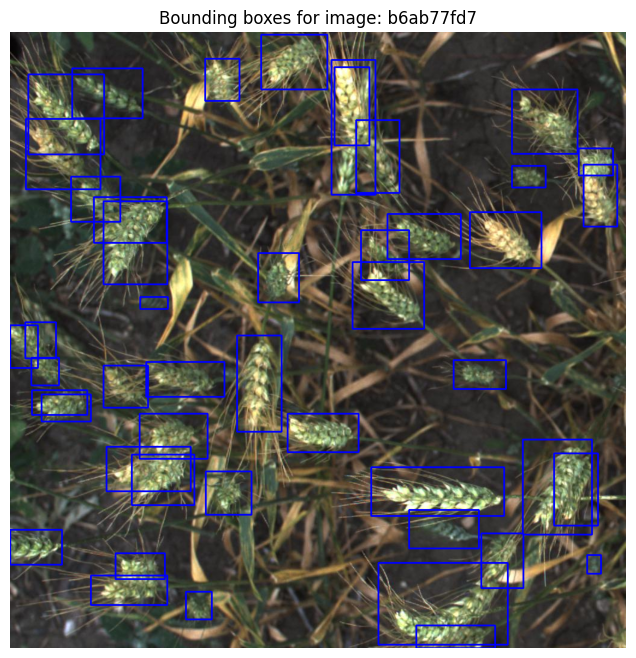

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import ast
import os

# Load annotations
df = pd.read_csv("/content/train.csv")

# Convert bbox string to list
df['bbox'] = df['bbox'].apply(ast.literal_eval)

print(df.head())

# Show sample image with bounding boxes
sample = df.iloc[0]
image_id = sample['image_id']
image_path = f"/content/train/{image_id}.jpg"

# Check if the image file exists
if os.path.exists(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        for _, row in df[df.image_id == image_id].iterrows():
            x, y, w, h = row['bbox']
            cv2.rectangle(img, (int(x), int(y)), (int(x+w), int(y+h)), (255, 0, 0), 2)

        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"Bounding boxes for image: {image_id}")
        plt.show()
    else:
        print(f"Error: Could not load image from {image_path}")
else:
    print(f"Error: Image file not found at {image_path}")

In [10]:
from sklearn.model_selection import train_test_split
import os

# Unique image IDs
image_ids = df['image_id'].unique()

# 80% train, 20% test
train_ids, test_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

# Split the dataframe
train_df = df[df['image_id'].isin(train_ids)]
test_df = df[df['image_id'].isin(test_ids)]

print(f"Train images: {len(train_ids)}, Test images: {len(test_ids)}")

# Output directory (Kaggle writable path)
output_dir = "/content/working/wheat_dataset"
os.makedirs(output_dir, exist_ok=True)

# Save split CSVs to /kaggle/working
train_df.to_csv(os.path.join(output_dir, "train_split.csv"), index=False)
test_df.to_csv(os.path.join(output_dir, "test_split.csv"), index=False)

print("CSV files saved to:", output_dir)


Train images: 2698, Test images: 675
CSV files saved to: /content/working/wheat_dataset


In [11]:
import pandas as pd
import ast
import os
import shutil
import cv2
from sklearn.model_selection import train_test_split

# Paths
DATA_DIR = "/content/"  # Dataset input directory
IMG_DIR = f"{DATA_DIR}/train"
YOLO_DIR = "/content/working/yolo_wheat_dataset"    # Output directory for YOLO

# Create directories
os.makedirs(f"{YOLO_DIR}/images/train", exist_ok=True)
os.makedirs(f"{YOLO_DIR}/images/val", exist_ok=True)
os.makedirs(f"{YOLO_DIR}/labels/train", exist_ok=True)
os.makedirs(f"{YOLO_DIR}/labels/val", exist_ok=True)

# Load annotations
df = pd.read_csv(f"{DATA_DIR}/train.csv")
df['bbox'] = df['bbox'].apply(ast.literal_eval)

# Split
image_ids = df['image_id'].unique()
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

def convert_and_save(df_split, split):
    for image_id in df_split['image_id'].unique():
        img_path = f"{IMG_DIR}/{image_id}.jpg"
        label_path = f"{YOLO_DIR}/labels/{split}/{image_id}.txt"

        # Copy image
        dest_img_path = f"{YOLO_DIR}/images/{split}/{image_id}.jpg"
        try:
            shutil.copy(img_path, dest_img_path)
        except Exception as e:
            print(f"Failed to copy {img_path}: {e}")
            continue

        # Get image size
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not read image {img_path}. Skipping.")
            continue

        h_img, w_img, _ = img.shape

        # Write YOLO label file
        with open(label_path, "w") as f:
            for _, row in df_split[df_split.image_id == image_id].iterrows():
                x, y, w, h = row['bbox']
                x_c = (x + w / 2) / w_img
                y_c = (y + h / 2) / h_img
                w /= w_img
                h /= h_img
                f.write(f"0 {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}\n")

# Save train and val splits
convert_and_save(df[df['image_id'].isin(train_ids)], "train")
convert_and_save(df[df['image_id'].isin(val_ids)], "val")

print("✅ YOLO dataset created at:", YOLO_DIR)

✅ YOLO dataset created at: /content/working/yolo_wheat_dataset


In [12]:
# Create YAML content
wheat_yaml = """
path: /content/working/yolo_wheat_dataset
train: images/train
val: images/val

nc: 1
names: ["wheat_head"]
"""

# Save to /kaggle/working (writable directory)
with open("/content/working/wheat.yaml", "w") as f:
    f.write(wheat_yaml)

print("✅ wheat.yaml generated at /content/working/wheat.yaml")


✅ wheat.yaml generated at /content/working/wheat.yaml


In [14]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.train(
    data="/content/working/wheat.yaml",
    epochs=20,
    imgsz=640,
    batch=16,
    workers=2
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/working/wheat.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c56f95d7290>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [15]:
import os
import time

# Absolute path to validation images
img_path = "/content/working/yolo_wheat_dataset/images/val"

# Get first 50 images
test_imgs = [os.path.join(img_path, f) for f in os.listdir(img_path) if f.endswith(".jpg")][:50]

# Inference + speed test
start = time.time()
for img in test_imgs:
    _ = model(img)  # run inference (you can store results if needed)
end = time.time()

# Calculate FPS
fps = len(test_imgs) / (end - start)
print(f"Inference Speed: {fps:.2f} FPS")


image 1/1 /content/working/yolo_wheat_dataset/images/val/32494cc53.jpg: 640x640 60 wheat_heads, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/working/yolo_wheat_dataset/images/val/ad0d224d6.jpg: 640x640 37 wheat_heads, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/working/yolo_wheat_dataset/images/val/618e1cac0.jpg: 640x640 49 wheat_heads, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/working/yolo_wheat_dataset/images/val/56c1bc7f0.jpg: 640x640 41 wheat_heads, 10.1ms
Speed: 4.0ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/working/yolo_wheat_dataset/images/val/c6d94be4c.jpg: 640x640 17 wheat_heads, 11.4ms
Speed: 4.0ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)



In [16]:
results = model.predict(
    source="/content/working/yolo_wheat_dataset/images/val",  # ✅ Use absolute path
    save=True,
    conf=0.25
)


image 1/675 /content/working/yolo_wheat_dataset/images/val/005b0d8bb.jpg: 640x640 25 wheat_heads, 7.3ms
image 2/675 /content/working/yolo_wheat_dataset/images/val/00764ad5d.jpg: 640x640 39 wheat_heads, 7.3ms
image 3/675 /content/working/yolo_wheat_dataset/images/val/00b70a919.jpg: 640x640 8 wheat_heads, 7.3ms
image 4/675 /content/working/yolo_wheat_dataset/images/val/01189a3c3.jpg: 640x640 35 wheat_heads, 7.3ms
image 5/675 /content/working/yolo_wheat_dataset/images/val/013669953.jpg: 640x640 19 wheat_heads, 7.3ms
image 6/675 /content/working/yolo_wheat_dataset/images/val/01e2c61d9.jpg: 640x640 33 wheat_heads, 7.3ms
image 7/675 /content/working/yolo_wheat_dataset/images/val/025ea7326.jpg: 640x640 14 wheat_heads, 7.3ms
image 8/675 /content/working/yolo_wheat_dataset/images/val/03173a1a5.jpg: 640x640 26 wheat_heads, 8.1ms
image 9/675 /content/working/yolo_wheat_dataset/images/val/038432e90.jpg: 640x640 80 wheat_heads, 7.3ms
image 10/675 /content/working/yolo_wheat_dataset/images/val/03a2

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:03<00:00, 49.5MB/s]
100%|██████████| 675/675 [10:04<00:00,  1.12it/s]


Epoch [1/5], Loss: 599.7763


100%|██████████| 675/675 [09:59<00:00,  1.13it/s]


Epoch [2/5], Loss: 519.5000


100%|██████████| 675/675 [10:00<00:00,  1.12it/s]


Epoch [3/5], Loss: 493.9573


100%|██████████| 675/675 [10:00<00:00,  1.12it/s]


Epoch [4/5], Loss: 476.5498


100%|██████████| 675/675 [10:00<00:00,  1.12it/s]


Epoch [5/5], Loss: 464.0522


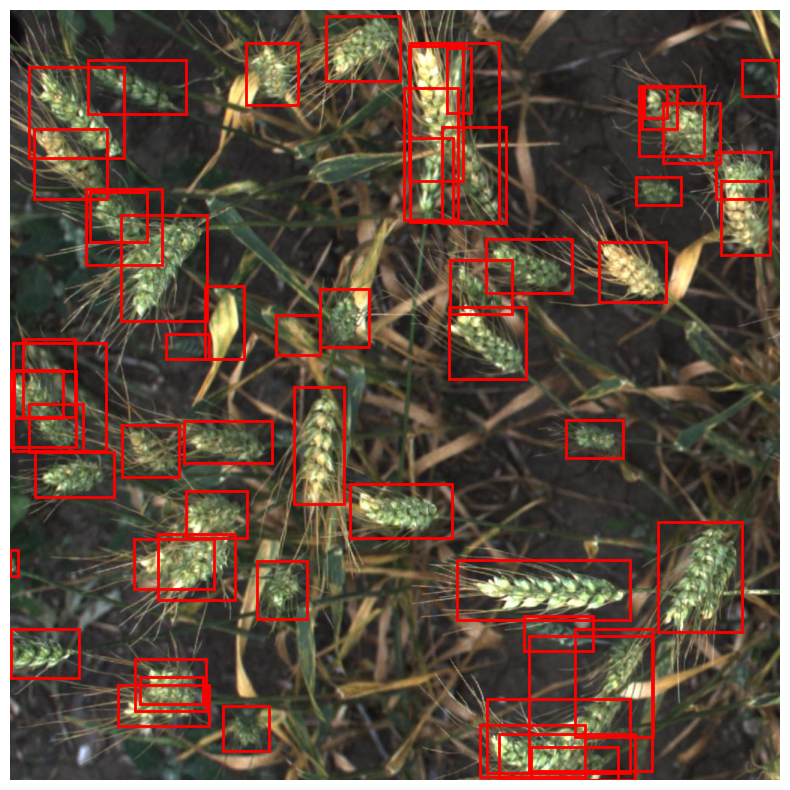

✅ Model saved.


In [17]:
import os
import ast
import pandas as pd
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from tqdm import tqdm

class WheatDataset(Dataset):
    def __init__(self, df, img_dir, transforms=None):
        self.df = df
        self.img_dir = img_dir
        self.image_ids = df['image_id'].unique()
        self.transforms = transforms

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        records = self.df[self.df['image_id'] == image_id]
        img_path = os.path.join(self.img_dir, f"{image_id}.jpg")

        img = Image.open(img_path).convert("RGB")

        boxes = []
        for _, row in records.iterrows():
            x, y, w, h = ast.literal_eval(row['bbox']) if isinstance(row['bbox'], str) else row['bbox']
            boxes.append([x, y, x + w, y + h])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((records.shape[0],), dtype=torch.int64)  # class 1: wheat
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'area': area,
            'iscrowd': iscrowd
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_ids)


# Load and prepare dataframe
df = pd.read_csv("/content/train.csv")
df['bbox'] = df['bbox'].apply(lambda x: ast.literal_eval(x))

# Split train/val
from sklearn.model_selection import train_test_split
image_ids = df['image_id'].unique()
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)
train_df = df[df['image_id'].isin(train_ids)]
val_df = df[df['image_id'].isin(val_ids)]

# Image directory
IMG_DIR = "/content/train"

# Transforms
transforms = T.Compose([
    T.ToTensor()
])

# Datasets
train_dataset = WheatDataset(train_df, IMG_DIR, transforms=transforms)
val_dataset = WheatDataset(val_df, IMG_DIR, transforms=transforms)

# Dataloaders
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)


def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Wheat has 1 class + background
model = get_model(num_classes=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, targets in tqdm(train_loader):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_image_with_boxes(img_tensor, boxes):
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(img_np)
    for box in boxes:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.axis("off")
    plt.show()

# Run inference on one image
model.eval()
with torch.no_grad():
    img, _ = val_dataset[0]
    prediction = model([img.to(device)])
    show_image_with_boxes(img, prediction[0]['boxes'].cpu())


torch.save(model.state_dict(), "/content/working/fasterrcnn_wheat.pth")
print("✅ Model saved.")


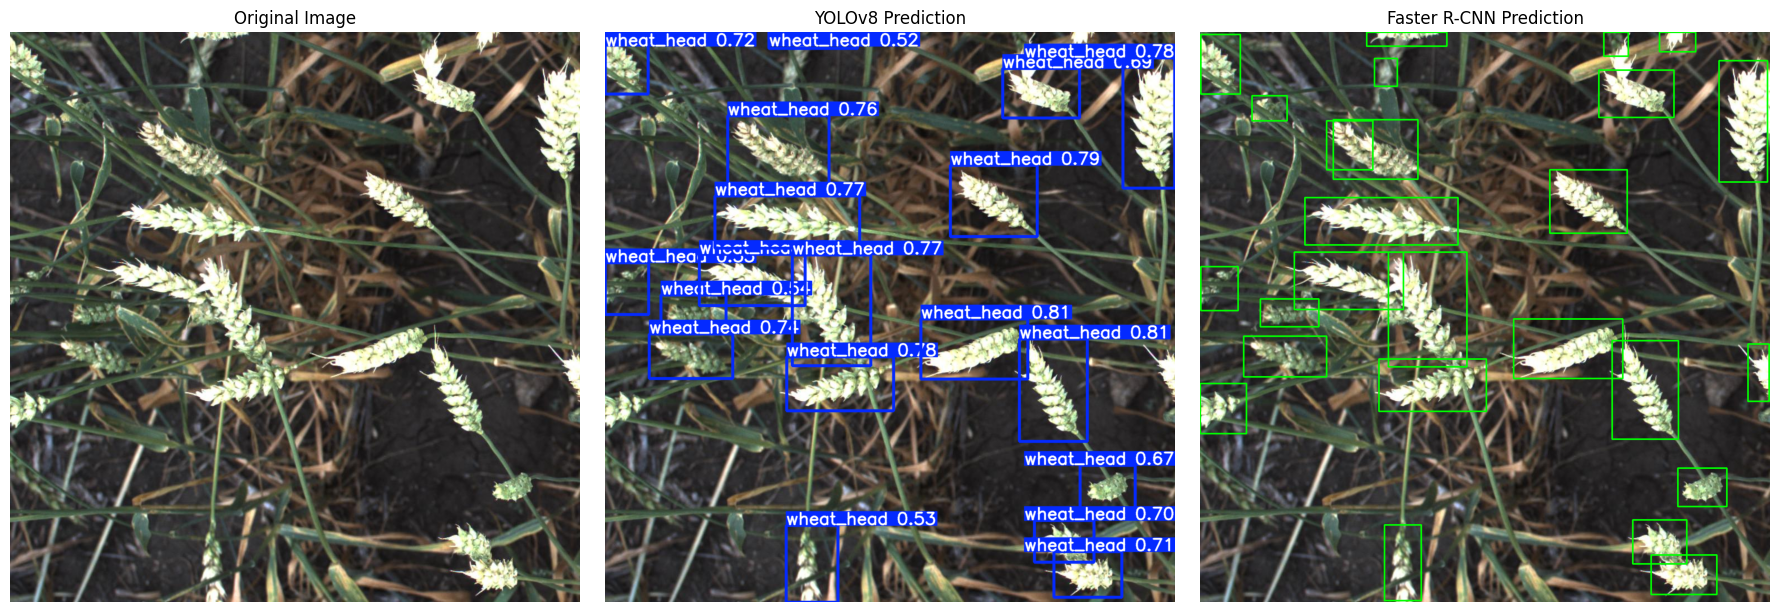

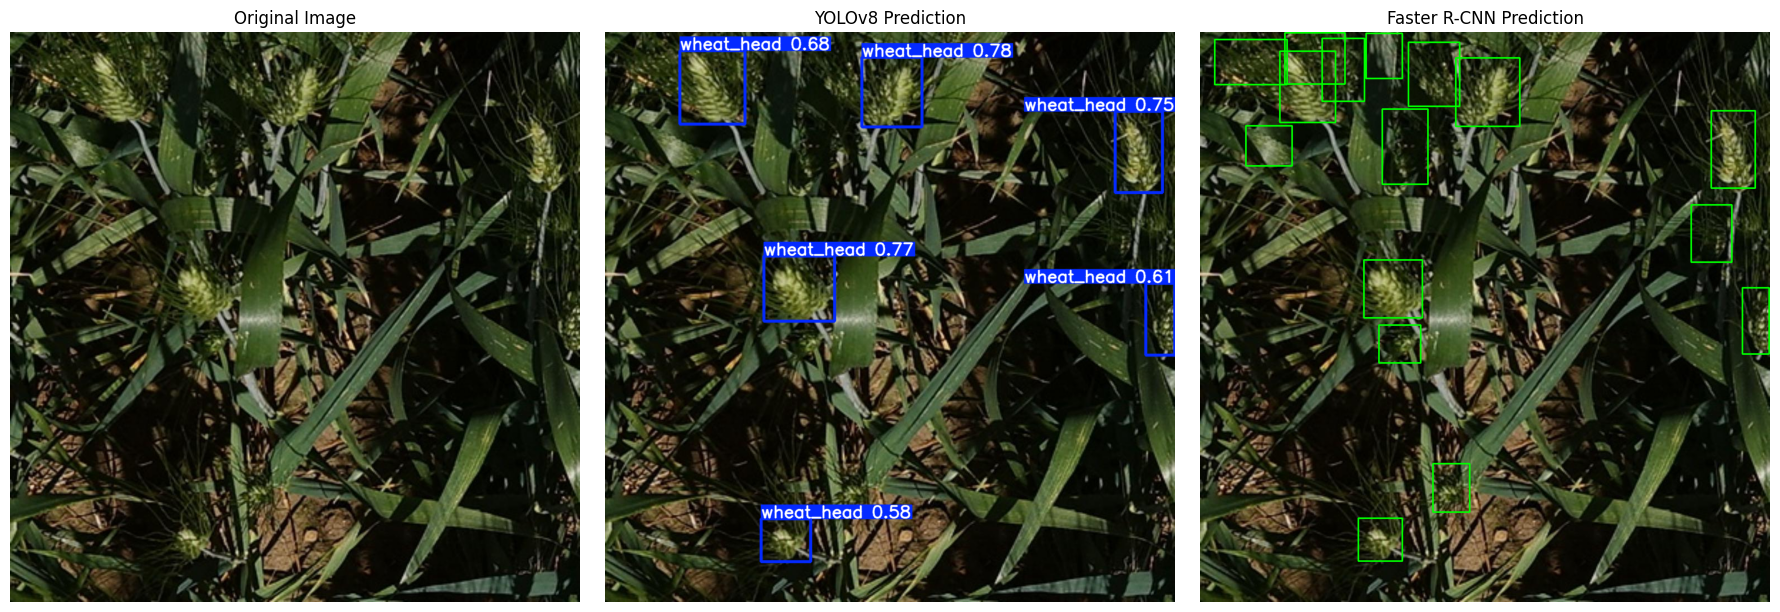

In [19]:
import torch
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import os

# ----------------------------
# Load trained YOLOv8 model
# ----------------------------
yolo_model = YOLO("/content/runs/detect/train/weights/best.pt")  # adjust if different

# ----------------------------
# Load trained Faster R-CNN
# ----------------------------
fasterrcnn_model = fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Modify classifier
num_classes = 2  # wheat + background
in_features = fasterrcnn_model.roi_heads.box_predictor.cls_score.in_features
fasterrcnn_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load trained weights
fasterrcnn_model.load_state_dict(torch.load("/content/working/fasterrcnn_wheat.pth", map_location="cpu"))

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fasterrcnn_model.to(device)
fasterrcnn_model.eval()

# ----------------------------
# Inference functions
# ----------------------------
transform = transforms.ToTensor()

def infer_fasterrcnn(img_path, score_thresh=0.5):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    tensor_img = transform(img_rgb).to(device)

    with torch.no_grad():
        preds = fasterrcnn_model([tensor_img])

    boxes, scores = preds[0]["boxes"], preds[0]["scores"]
    for box, score in zip(boxes, scores):
        if score >= score_thresh:
            x1, y1, x2, y2 = box.int().tolist()
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0,255,0), 2)
    return img_rgb

def infer_yolo(img_path, conf=0.5):
    results = yolo_model(img_path, conf=conf, verbose=False)
    img = results[0].plot()  # returns image with boxes (BGR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb

def compare_models(img_path):
    yolo_pred = infer_yolo(img_path)
    frcnn_pred = infer_fasterrcnn(img_path)

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(yolo_pred)
    axs[1].set_title("YOLOv8 Prediction")
    axs[1].axis("off")

    axs[2].imshow(frcnn_pred)
    axs[2].set_title("Faster R-CNN Prediction")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

# ----------------------------
# Run Example
# ----------------------------
# Replace with a real val image path
test_image = "/content/working/yolo_wheat_dataset/images/val/005b0d8bb.jpg"
if os.path.exists(test_image):
    compare_models(test_image)
else:
    print(f"⚠️ Image not found: {test_image}")


# Bounes Tip
# Pick a random image from validation folder
val_dir = "/content/working/yolo_wheat_dataset/images/val"
val_imgs = [os.path.join(val_dir, f) for f in os.listdir(val_dir) if f.endswith(".jpg")]

import random
test_image = random.choice(val_imgs)
compare_models(test_image)